In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests


%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
#define confidence tests
def get_95_ci(x1, x2):
    """Calculate a 95% CI for 2 1d numpy arrays"""
    signal = x1.mean() - x2.mean()
    noise = np.sqrt(x1.var() / x1.size + x2.var() / x2.size)

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    return ci_lo, ci_hi

def calc_non_param_ci(x1, x2, alpha=0.05):
    """Calc confidence interval for 2 group median test

    Process:
      * Find all pairwise diffs
      * Sort diffs
      * Find appropriate value of k
      * Choose lower bound from diffs as: diffs[k]
      * Choose upper bound from diffs as: diffs[-k]

    Based on: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2545906/

    :param x1: sample 1
    :param x2: sample 2
    :param alpha: significance level
    :return: (tuple) confidence interval bounds
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    n1 = x1.size
    n2 = x2.size
    cv = stats.norm.ppf(1 - alpha / 2)

    # Find pairwise differences for every datapoint in each group
    diffs = (x1[:, None] - x2).flatten()
    diffs.sort()

    # For an approximate (1-a)% confidence interval first calculate K:
    k = int(round(n1 * n2 / 2 - (cv * (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5)))

    # The Kth smallest to the Kth largest of the n x m differences
    # n1 and n2 should be > ~20
    ci_lo = diffs[k]
    ci_hi = diffs[-k]

    return ci_lo, ci_hi


<IPython.core.display.Javascript object>

## Load in the dataframe, see the shape of it, and create a few identifier variables ##

In [4]:
data_path = "data/charting-m-points.csv"
df = pd.read_csv(data_path, encoding="ISO-8859-1")

/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,8,9,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<IPython.core.display.Javascript object>

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439988 entries, 0 to 439987
Data columns (total 48 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   match_id       439988 non-null  object 
 1   Pt             439988 non-null  int64  
 2   Set1           439988 non-null  int64  
 3   Set2           439988 non-null  int64  
 4   Gm1            439987 non-null  float64
 5   Gm2            439987 non-null  float64
 6   Pts            439988 non-null  object 
 7   Gm#            439987 non-null  object 
 8   TbSet          439988 non-null  object 
 9   TB?            439988 non-null  object 
 10  TBpt           15632 non-null   float64
 11  Svr            439988 non-null  int64  
 12  Ret            439988 non-null  int64  
 13  Serving        439375 non-null  object 
 14  1st            439988 non-null  object 
 15  2nd            166825 non-null  object 
 16  Notes          26591 non-null   object 
 17  1stSV          439988 non-nul

<IPython.core.display.Javascript object>

In [55]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 500)
# df["match_id"].head(5)
df.head(2)

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isRally1st,isRally2nd,Sv1,Sv2,Rally,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,rallyLen,PtWinner,isSvrWinner,PtsAfter,GmW,Gm1.1,Gm2.1,SetW,Set1.1,Set2.1,rallyCount,year,player1_id,player2_id,game,pt_game
0,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,1,0,0,0.0,0.0,0-0,1 (1),1,0,NaN,1,2,EG,6n,5b2n@,NaN,0,0.0,0,1.0,0,1,6n,5,b2n@,False,False,False,False,True,False,1,1,1,15-0,0,0,0,0,0,0,1,2020,Ernests_Gulbis,Mohamed_Safwat,1,1
1,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,2,0,0,0.0,0.0,15-0,1 (2),1,0,NaN,1,2,EG,5b37b3b1r3n#,NaN,NaN,0,NaN,1,NaN,1,0,5,NaN,b37b3b1r3n#,False,False,False,True,False,False,4,2,0,15-15,0,0,0,0,0,0,4,2020,Ernests_Gulbis,Mohamed_Safwat,1,2


<IPython.core.display.Javascript object>

In [7]:
df["year"] = df["match_id"].str[0:4].astype(int)
df['player1_id']=None
df['player2_id']=None
df['player2_id']=df["match_id"].str.split("-").str[-1]
df['player1_id']=df["match_id"].str.split("-").str[-2]

df['game']=df['Gm#'].str.split().str[0]#.astype(int)
df['pt_game']=df['Gm#'].str.split().str[1].str.strip(' ()')


<IPython.core.display.Javascript object>

In [8]:
# use only the columns I want
df_trim = df[
    [
        "match_id",
        "player1_id",
        "player2_id",
        "year",
        "Svr",
        "isDouble",
        "isAce",
        "PtWinner",
        "isSvrWinner",
        "Pt",
        "game",
    ]
]
# df_trim.head(10)

<IPython.core.display.Javascript object>

### Make variables that indicate if the point is within 1,2, or 3 points after a double fault ###

In [9]:
# Here, I'm making indicating boolean variables that are exactly 1,2,and 3 points after a double fault

df_trim["after_double"] = df_trim["isDouble"]
df_trim["after_double1"] = df_trim.groupby(by=["match_id", "game"])[
    "after_double"
].shift(
    periods=1, fill_value=False
)  #
df_trim["after_double2"] = df_trim.groupby(by=["match_id", "game"])[
    "after_double1"
].shift(periods=1, fill_value=False)
df_trim["after_double3"] = df_trim.groupby(by=["match_id", "game"])[
    "after_double2"
].shift(periods=1, fill_value=False)

/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

<IPython.core.display.Javascript object>

In [10]:
# Make an indicator for after losing a point as a control variable for tests below

df_trim["serverloss"] = df_trim["isSvrWinner"].astype(bool)
df_trim["serverloss"] = ~df_trim["serverloss"]
df_trim["after_serverloss"] = df_trim.groupby(by=["match_id", "game"])[
    "serverloss"
].shift(periods=1, fill_value=False)

/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be s

<IPython.core.display.Javascript object>

Now, I'm going to make the booleans indicate if they were **within** a certain number of points after a double fault

In [12]:
df_trim.loc[df_trim["after_double1"] == True, ["after_double2", "after_double3"]] = True

/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<IPython.core.display.Javascript object>

In [13]:
df_trim.loc[df_trim["after_double2"] == True, ["after_double3"]] = True

<IPython.core.display.Javascript object>

Now, melt the dataset so that each player has their own row for each point, then create a dataset server_df, to only keep the points where the player is serving. No information will be lost from df_trim because one player is always serving.

In [56]:
df_trim.head(2)

,match_id,player1_id,player2_id,year,Svr,isDouble,isAce,PtWinner,isSvrWinner,Pt,game,after_double,after_double1,after_double2,after_double3,serverloss,after_serverloss
0,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,Ernests_Gulbis,Mohamed_Safwat,2020,1,False,False,1,1,1,1,False,False,False,False,False,False
1,20200307-M-Davis_Cup_WG_II-RR-Ernests_Gulbis-M...,Ernests_Gulbis,Mohamed_Safwat,2020,1,False,False,2,0,2,1,False,False,False,False,True,False


<IPython.core.display.Javascript object>

In [15]:
melt_trim = pd.melt(
    df_trim,
    id_vars=[
        "match_id",
        "year",
        "Pt",
        "Svr",
        "isAce",
        "game",
        "PtWinner",
        "isSvrWinner",
        "isDouble",
        "after_double1",
        "after_double2",
        "after_double3",
    ],
    value_vars=["player1_id", "player2_id"],
    var_name="player_number",
    value_name="player_name",
)
melt_trim["player_number"] = (
    melt_trim["player_number"]
    .replace(["player1_id", "player2_id"], ["1", "2"])
    .astype(int)
)
server_df = melt_trim[melt_trim["player_number"] == melt_trim["Svr"]]
server_df = server_df.sort_values(by=["match_id", "Pt"])
server_df = server_df.rename(columns={"player_name": "server_name"})

<IPython.core.display.Javascript object>

In [57]:
server_df.head(4)
# server_df.info()

,match_id,year,Pt,Svr,isAce,game,PtWinner,isSvrWinner,isDouble,after_double1,after_double2,after_double3,player_number,server_name
439687,19700704-M-Wimbledon-F-John_Newcombe-Ken_Rosewall,1970,1,1,False,1,1,1,False,False,False,False,1,John_Newcombe
439688,19700704-M-Wimbledon-F-John_Newcombe-Ken_Rosewall,1970,2,1,False,1,2,0,False,False,False,False,1,John_Newcombe
439689,19700704-M-Wimbledon-F-John_Newcombe-Ken_Rosewall,1970,3,1,False,1,1,1,False,False,False,False,1,John_Newcombe
439690,19700704-M-Wimbledon-F-John_Newcombe-Ken_Rosewall,1970,4,1,False,1,1,1,False,False,False,False,1,John_Newcombe


<IPython.core.display.Javascript object>

### Make datasets consisting of points after a double fault: ### 

In [17]:
server_isDouble = server_df[server_df["isDouble"] == True]
server_after_double1 = server_df[server_df["after_double1"] == True]
server_after_double2 = server_df[server_df["after_double2"] == True]
server_after_double3 = server_df[server_df["after_double3"] == True]

<IPython.core.display.Javascript object>

### Take the means on a per match and per player basis and look at the shape ###

***Per-match basis:***

In [18]:
server_df_match_means= server_df.groupby('match_id').agg(year=('year', 'min'), ServeWinnerMean=('isSvrWinner', 'mean'), PtsTotal=('Pt', 'count'), ServeWinnerSum=('isSvrWinner', 'sum'))
server_df_match_means['pts_after_fault']=0
server_after_double1_match_means=server_after_double1.groupby('match_id').agg(year=('year', 'min'), ServeWinnerMean=('isSvrWinner', 'mean'), PtsTotal=('Pt', 'count'), ServeWinnerSum=('isSvrWinner', 'sum'))
server_after_double1_match_means['pts_after_fault']=1

server_after_double2_match_means=server_after_double2.groupby('match_id').agg(year=('year', 'min'), ServeWinnerMean=('isSvrWinner', 'mean'), PtsTotal=('Pt', 'count'), ServeWinnerSum=('isSvrWinner', 'sum'))
server_after_double2_match_means['pts_after_fault']=2

server_after_double3_match_means=server_after_double3.groupby('match_id').agg(year=('year', 'min'), ServeWinnerMean=('isSvrWinner', 'mean'), PtsTotal=('Pt', 'count'), ServeWinnerSum=('isSvrWinner', 'sum'))
server_after_double3_match_means['pts_after_fault']=3


<IPython.core.display.Javascript object>

**Per-player basis:**

In [19]:
server_df_player_means= server_df.groupby('server_name').agg(firstyear=('year', 'min'), TotalWinnerMean=('isSvrWinner', 'mean'), TotalPtsTotal=('Pt', 'count'), TotalServeWinnerSum=('isSvrWinner', 'sum'))
server_after_double1_player_means=server_after_double1.groupby('server_name').agg(Double1WinnerMean=('isSvrWinner', 'mean'), Double1PtsTotal=('Pt', 'count'), Double1WinnerSum=('isSvrWinner', 'sum'))
server_after_double2_player_means=server_after_double2.groupby('server_name').agg(Double2WinnerMean=('isSvrWinner', 'mean'), Double2PtsTotal=('Pt', 'count'), Double2WinnerSum=('isSvrWinner', 'sum'))
server_after_double3_player_means=server_after_double3.groupby('server_name').agg(Double3WinnerMean=('isSvrWinner', 'mean'), Double3PtsTotal=('Pt', 'count'), Double3WinnerSum=('isSvrWinner', 'sum'))


<IPython.core.display.Javascript object>

In [20]:
server_df_player_means[server_df_player_means["TotalPtsTotal"] > 100].head()

,firstyear,TotalWinnerMean,TotalPtsTotal,TotalServeWinnerSum
server_name,,,,
Aaron_Krickstein,1989,0.508897,281,143
Adam_Pavlasek,2016,0.622340,188,117
Adrian_Mannarino,2015,0.613445,595,365
Adriano_Panatta,1974,0.490909,110,54
Albert_Costa,1996,0.580537,298,173


<IPython.core.display.Javascript object>

**Now append the match datasets:**

In [21]:
# append the datasets, note: find a better name
appended_server = (
    server_df_match_means.append(server_after_double1_match_means, ignore_index=False)
    .append(server_after_double2_match_means, ignore_index=False)
    .append(server_after_double3_match_means, ignore_index=False)
)


<IPython.core.display.Javascript object>

**Merge the player datasets (I'm doing this rather than append because it was a pain to only keep players who have hit a certain number of serves in the appended version)**

In [22]:
merged_players = (
    server_df_player_means.merge(
        server_after_double1_player_means, left_on="server_name", right_on="server_name"
    )
    .merge(
        server_after_double2_player_means, left_on="server_name", right_on="server_name"
    )
    .merge(
        server_after_double3_player_means, left_on="server_name", right_on="server_name"
    )
)

<IPython.core.display.Javascript object>

### Now we'll see if there is a difference of means for the match level data ###

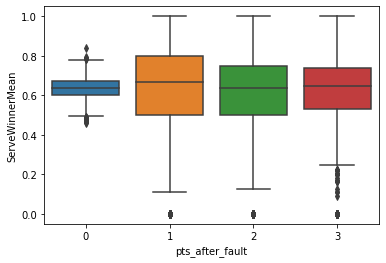

<IPython.core.display.Javascript object>

In [23]:
ax = sns.boxplot(x="pts_after_fault", y="ServeWinnerMean", data=appended_server)

**Checking for normality:**

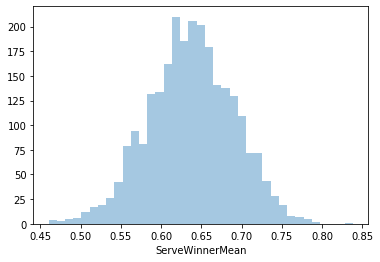

<IPython.core.display.Javascript object>

In [24]:
overall_ptwins_plt = sns.distplot(server_df_match_means["ServeWinnerMean"], kde=False)

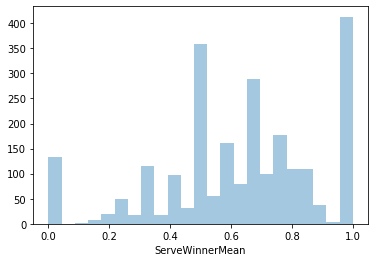

<IPython.core.display.Javascript object>

In [25]:
double1_ptwins_plt = sns.distplot(
    server_after_double1_match_means["ServeWinnerMean"], kde=False
)

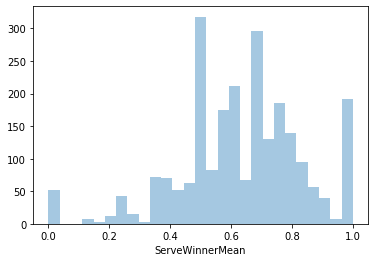

<IPython.core.display.Javascript object>

In [26]:
double2_ptwins_plt = sns.distplot(
    server_after_double2_match_means["ServeWinnerMean"], kde=False
)

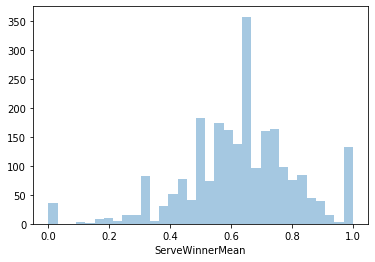

<IPython.core.display.Javascript object>

In [27]:
double3_ptwins_plt = sns.distplot(
    server_after_double3_match_means["ServeWinnerMean"], kde=False
)

**The distribution of means for the proportion of points won after a double fault are clearly not normal.** This is likely because there are so few double faults per match. **We might need to use a Chi-squared or Fischer's exact test to compare the proportion of points won after a double fault to the control (proportion of points won during all serves).**

**However, first, I can try a non-parametric test for non-normal, dependent datasets (ie Wilcoxon).** Unfortunately, even though they're dependent (the control includes datapoints where there is a doublefault), they are not the same length. **For now, I'll try to get away with a test for non-normal, independent datasets (Mann-Whitney U)**

In [28]:
stats.mannwhitneyu(
    server_after_double1_match_means["ServeWinnerMean"],
    server_df_match_means["ServeWinnerMean"],
)

MannwhitneyuResult(statistic=3010791.5, pvalue=0.1214091992647981)

<IPython.core.display.Javascript object>

In [29]:
calc_non_param_ci(
    server_after_double1_match_means["ServeWinnerMean"],
    server_df_match_means["ServeWinnerMean"],
    alpha=0.05,
)

(-0.003968253968253954, 0.016129032258064502)

<IPython.core.display.Javascript object>

It's close! You can almost see that servers actually have a higher win percentage after a double fault. But at the .05 significance level, players don't seem to play better or worse after a double fault.

### On to Chi-squared/Fisher's exact! ###

In [30]:
# First, find the total sums for all the matches in the database,
# grouped by how many points the data is after a double:
total_serve_sums = appended_server.groupby("pts_after_fault").agg(
    PtsTotal=("PtsTotal", "sum"), ServeWinnerSum=("ServeWinnerSum", "sum")
)
total_serve_sums["ServeLoserSum"] = (
    total_serve_sums["PtsTotal"] - total_serve_sums["ServeWinnerSum"]
)
total_serve_sums["WinServeMean"] = (
    total_serve_sums["ServeWinnerSum"] / total_serve_sums["PtsTotal"]
)
total_serve_sums


,PtsTotal,ServeWinnerSum,ServeLoserSum,WinServeMean
pts_after_fault,,,,
0,439988,281486,158502,0.639758
1,13248,8377,4871,0.632322
2,24009,15279,8730,0.636386
3,32163,20487,11676,0.636974


<IPython.core.display.Javascript object>

In [31]:
# I'll focus on only the point after double faults
chisq_table = total_serve_sums[["ServeWinnerSum", "ServeLoserSum"]].head(2)
chisq_table

,ServeWinnerSum,ServeLoserSum
pts_after_fault,,
0,281486,158502
1,8377,4871


<IPython.core.display.Javascript object>

In [32]:
# Now, use Chi-Squared test because we have many observations
f_obs = np.array([chisq_table.iloc[0][0:2].values, chisq_table.iloc[1][0:2].values])
stats.chi2_contingency(f_obs)[0:3]

(3.0529973445366796, 0.08058828712452745, 1)

<IPython.core.display.Javascript object>

It seems like the tour as a whole do not perform worse after a double fault at the .05 significance level!

### Now to look at player data and see if they perform worse after a double fault ###

In [33]:
merged_players.head()

,firstyear,TotalWinnerMean,TotalPtsTotal,TotalServeWinnerSum,Double1WinnerMean,Double1PtsTotal,Double1WinnerSum,Double2WinnerMean,Double2PtsTotal,Double2WinnerSum,Double3WinnerMean,Double3PtsTotal,Double3WinnerSum
server_name,,,,,,,,,,,,,
Aaron_Krickstein,1989,0.508897,281,143,0.750000,4,3,0.428571,7,3,0.500000,10,5
Adam_Pavlasek,2016,0.622340,188,117,0.333333,3,1,0.333333,6,2,0.375000,8,3
Adrian_Mannarino,2015,0.613445,595,365,0.100000,10,1,0.294118,17,5,0.380952,21,8
Adriano_Panatta,1974,0.490909,110,54,0.666667,3,2,0.500000,4,2,0.500000,4,2
Adrien_Bossel,2015,0.428571,42,18,0.000000,1,0,0.000000,1,0,0.000000,1,0


<IPython.core.display.Javascript object>

Seems like we have around 500 players worth of data. What about those who played a significant amount of tennis, who have, say, more than 200 points charted? This way we won't get a lof of information from people who didn't hit a double fault in the one match they charted. (You serve an average of around 70 times a match)

In [34]:
merged_players_many = merged_players[merged_players["TotalPtsTotal"] > 200]
merged_players_many.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247 entries, Aaron_Krickstein to Yoshihito_Nishioka
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   firstyear            247 non-null    int64  
 1   TotalWinnerMean      247 non-null    float64
 2   TotalPtsTotal        247 non-null    int64  
 3   TotalServeWinnerSum  247 non-null    int64  
 4   Double1WinnerMean    247 non-null    float64
 5   Double1PtsTotal      247 non-null    int64  
 6   Double1WinnerSum     247 non-null    int64  
 7   Double2WinnerMean    247 non-null    float64
 8   Double2PtsTotal      247 non-null    int64  
 9   Double2WinnerSum     247 non-null    int64  
 10  Double3WinnerMean    247 non-null    float64
 11  Double3PtsTotal      247 non-null    int64  
 12  Double3WinnerSum     247 non-null    int64  
dtypes: float64(4), int64(9)
memory usage: 27.0+ KB


<IPython.core.display.Javascript object>

I'll use these players for most of the analysis. This will exclude most players who only played one match and hit one or zero double faults.

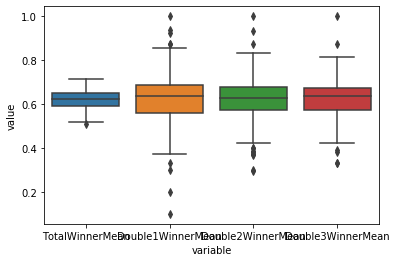

<IPython.core.display.Javascript object>

In [35]:
boxdata = merged_players_many[
    ["TotalWinnerMean", "Double1WinnerMean", "Double2WinnerMean", "Double3WinnerMean"]
]
ax = sns.boxplot(x="variable", y="value", data=pd.melt(boxdata))

I need to figure out how to relabel the x values above. In any case, it seem like there might be an increase in win probability for the player level data.

From just glancing at this data, it seems these top players actually may play **better** after double faulting.

### Let's test to see if there is a differnce in play for individual players after double faulting.###

**First, see if we can assume normality**


DescribeResult(nobs=247, minmax=(0.5088967971530249, 0.7130289065772937), mean=0.6218437322161652, variance=0.00160467383705652, skewness=-0.18452861296603937, kurtosis=-0.15170118485826478)


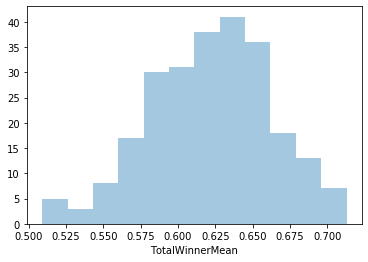

<IPython.core.display.Javascript object>

In [36]:
print(stats.describe(merged_players_many["TotalWinnerMean"]))
sns.distplot(
    merged_players_many["TotalWinnerMean"], kde=False,
)

Looks normal

DescribeResult(nobs=247, minmax=(0.1, 1.0), mean=0.6216449151043774, variance=0.014312973472646309, skewness=-0.39937686667629485, kurtosis=1.760430154822024)


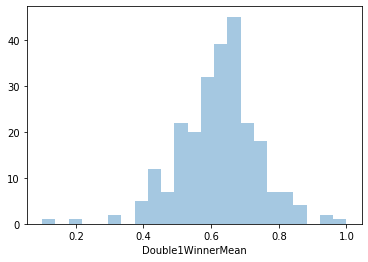

<IPython.core.display.Javascript object>

In [37]:
print(stats.describe(merged_players_many["Double1WinnerMean"]))
sns.distplot(merged_players_many["Double1WinnerMean"], kde=False)


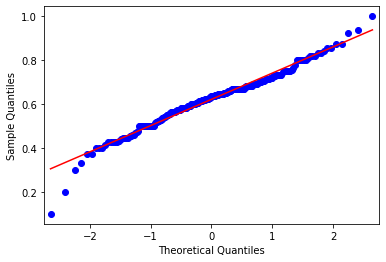

<IPython.core.display.Javascript object>

In [38]:
qqplot(merged_players_many["Double1WinnerMean"], line="s")
plt.show()

The looks normal to me.

DescribeResult(nobs=247, minmax=(0.29411764705882354, 1.0), mean=0.6244467604722902, variance=0.00976811073133373, skewness=-0.2021264731188311, kurtosis=1.5987447912237016)


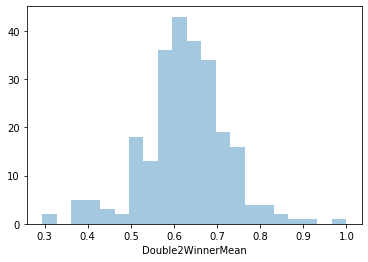

<IPython.core.display.Javascript object>

In [39]:
print(stats.describe(merged_players_many["Double2WinnerMean"]))
sns.distplot(merged_players_many["Double2WinnerMean"], kde=False)


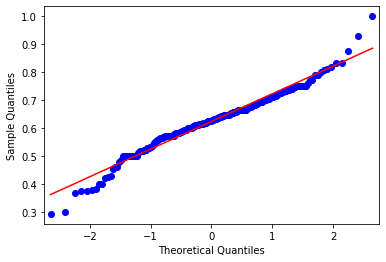

<IPython.core.display.Javascript object>

In [40]:
merged_players_many["Double2WinnerMean"]
qqplot(merged_players_many["Double2WinnerMean"], line="s")
plt.show()

DescribeResult(nobs=247, minmax=(0.3333333333333333, 1.0), mean=0.6229772323371209, variance=0.007967057942169833, skewness=-0.13803327718727693, kurtosis=1.517241574508354)


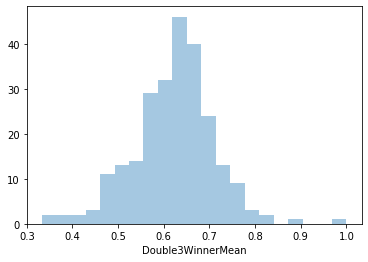

<IPython.core.display.Javascript object>

In [41]:
print(stats.describe(merged_players_many["Double3WinnerMean"]))
sns.distplot(merged_players_many["Double3WinnerMean"], kde=False)


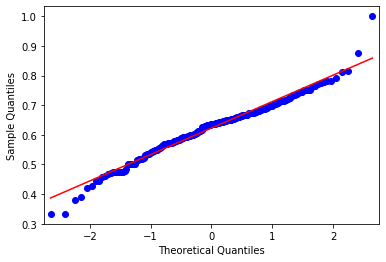

<IPython.core.display.Javascript object>

In [42]:
merged_players_many["Double3WinnerMean"]
qqplot(merged_players_many["Double3WinnerMean"], line="s")
plt.show()

DescribeResult(nobs=247, minmax=(-0.5134453781512606, 0.33333333333333337), mean=-0.00019881711178782488, variance=0.012941442069818862, skewness=-0.1466624100195591, kurtosis=1.6736456709618368)


/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


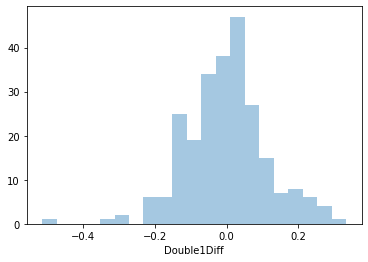

<IPython.core.display.Javascript object>

In [43]:
#Look at the difference for a paired ttest
#lower means you lose more points after a double fault for 'double1Diff' below
merged_players['Double1Diff']=merged_players["Double1WinnerMean"]-merged_players["TotalWinnerMean"]
merged_players_many['Double1Diff']=merged_players_many["Double1WinnerMean"]-merged_players_many["TotalWinnerMean"]
print(stats.describe(merged_players_many["Double1Diff"]))
sns.distplot(merged_players_many["Double1Diff"], kde=False)


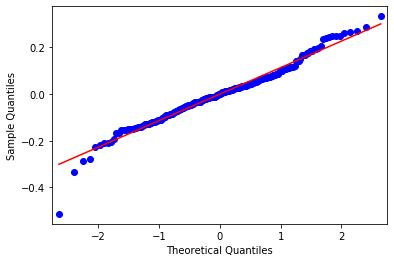

<IPython.core.display.Javascript object>

In [44]:
qqplot(merged_players_many["Double1Diff"], line="s")
plt.show()

I think we can call all these normal.

At the moment, I only want to test to see if there is an effect on the point directly after double faulting, so I'll use the t-test.

In [45]:
stats.ttest_rel(
    merged_players_many["TotalWinnerMean"], merged_players_many["Double1WinnerMean"]
)

Ttest_relResult(statistic=0.027466979339477605, pvalue=0.9781095454153708)

<IPython.core.display.Javascript object>

**I think that we can pretty confidently say here that double-faulting does not affect your performance on subsequent points on the individual player level!**

Some sources of bias in this sample are that we looked at only the top 250 or so players, so they might be more mentally resiliant as a whole. Also, the sample itself is a chart of more popular matches, so, especially for the earlier ones, the charted matches are going to more inherently be the higher level ones.

### I want to take a look at the top players who are most affected by double faults. ###

In [46]:
merged_players_many[["Double1Diff"]].sort_values(
    by=["Double1Diff"], ascending=True
).head(20)

,Double1Diff
server_name,
Adrian_Mannarino,-0.513445
Miroslav_Mecir,-0.332468
Todd_Woodbridge,-0.286498
Egor_Gerasimov,-0.279079
Pablo_Cuevas,-0.225625
Marat_Safin,-0.217606
Peter_Polansky,-0.211470
Andrey_Rublev,-0.209193
Albert_Costa,-0.205537


<IPython.core.display.Javascript object>

This is a pretty pleasing list. The best player here, Marat Safin, was known to have a terrible mental game. Many others, like Andrey Rublev and Hyeon Chung, are quite young.

In [47]:
# and those who are least affected
merged_players_many[["Double1Diff"]].sort_values(
    by=["Double1Diff"], ascending=False
).head(10)

,Double1Diff
server_name,
Andy_Murray_,0.333333
Rudolf_Molleker,0.286337
Henri_Leconte,0.269489
Victor_Estrella,0.267544
Lukas_Lacko,0.259937
Jarkko_Nieminen,0.249438
Alberto_Berasategui,0.248834
Lukas_Rosol,0.248609
Mirza_Basic,0.244863


<IPython.core.display.Javascript object>

Andy Murray is at the top of this list, but his name is in a non-standard format, so I suspect this is because of a match he did particularly well is that was entered incorrectly. I don't recognize the other people, which may mean that this isn't a super important determiner of being good at tennis.

**Speaking of which, I'll check to see how the best players in the world are in terms of the decrease in likelihood of winning a point after a double fault:**

In [48]:
# look up the "big four", often referred to the best tennis players of the modern era.
merged_players_many.loc[
    ["Roger_Federer", "Novak_Djokovic", "Rafael_Nadal", "Andy_Murray"], ["Double1Diff"]
]

,Double1Diff
server_name,
Roger_Federer,-0.039994
Novak_Djokovic,-0.011733
Rafael_Nadal,0.024052
Andy_Murray,0.009851


<IPython.core.display.Javascript object>

As I suspected, my favorite Roger Federer is probably the least mentally tough of the bunch.

## Finding the correlation between aggressiveness on second serve and the effect of double faults ##

Lastly, to tie all this together, I want to see if there is any correlation between being mentally affected by double faults and if you are more conservative on your second serve. To do this, I'll import the information from the first dataset on 'makewindiff' for individual players and merge that information with the dataset above, then take the correlation.

In [49]:
player_sums = pd.read_csv("player_sums.csv")
player_sums.head(2)

,player_id,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,year,first_out,second_total,second_out,matches_no,first_make_pct,first_win_pct,first_make_win,second_make_pct,second_win_pct,second_make_win,second_success,make_win_diff
0,Aaron_Krickstein,285,15,4,146,84,135,59,7967,139,139,4,4,0.512281,0.575342,0.294737,0.971223,0.437037,0.424460,0.207018,0.129724
1,Adam_Pavlasek,193,22,5,102,75,86,42,6054,91,91,5,3,0.528497,0.735294,0.388601,0.945055,0.488372,0.461538,0.217617,0.072937
2,Adrian_Mannarino,607,45,13,382,257,212,107,16143,225,225,13,8,0.629325,0.672775,0.423394,0.942222,0.504717,0.475556,0.176277,0.052162
3,Adriano_Panatta,113,2,3,69,37,41,17,1974,44,44,3,1,0.610619,0.536232,0.327434,0.931818,0.414634,0.386364,0.150442,0.058930
4,Adrien_Bossel,43,1,1,23,14,19,4,2015,20,20,1,1,0.534884,0.608696,0.325581,0.950000,0.210526,0.200000,0.093023,-0.125581


<IPython.core.display.Javascript object>

In [50]:
corr_data = player_sums.merge(
    merged_players, left_on="player_id", right_on="server_name"
)

<IPython.core.display.Javascript object>

In [51]:
corr_data = corr_data[["make_win_diff", "Double1Diff"]]

<IPython.core.display.Javascript object>

In [52]:
corr_data.head(2)

,make_win_diff,Double1Diff
0,0.129724,0.241103
1,0.072937,-0.289007


<IPython.core.display.Javascript object>

In [53]:
corr_data.corr(method="pearson")

,make_win_diff,Double1Diff
make_win_diff,1.000000,0.050835
Double1Diff,0.050835,1.000000


<IPython.core.display.Javascript object>

So we see almost no correlation between being conservative with serves and missing more second serves. Meaning that players who are more conservative are probably not responding to having a bad mental game.

As stated, most of the bias in this sample comes from who the match charters decide to chart. This will always lean toward the biggest players. Another, more insidious, source of bias for the individual player statistics is that any comparison of averages between them will be equally weighted, even though the biggest players have played more points

If I were to continue this research, I would like to see the effect that serve speed and placement has on winning. The placement variables are included in the points dataset, but not the speed sadly. Spin would also be incredibly useful to know, but that would be very difficult to find out.